In [189]:
'''
1) treating group selfies strings as actions?
2) if 1) yes, then does it matter if we loose attachment points?
'''

'\n1) treating group selfies strings as actions?\n2) if 1) yes, then does it matter if we loose attachment points?\n'

In [190]:
import torch
import random
import numpy as np
import selfies as sf
import torch_geometric
import group_selfies as gs
import torch.nn.functional as F

from rdkit import Chem
from copy import deepcopy
from dockstring import load_target
from global_chem import GlobalChem
from IPython.display import display
from collections import OrderedDict
from rdkit.Chem import Descriptors, Draw
from pathos.multiprocessing import ProcessingPool as Pool
from torch_geometric.utils.convert import to_networkx, from_networkx

def grid(mols, molsPerRow=10):
    return Draw.MolsToGridImage(mols, molsPerRow=molsPerRow, maxMols=1000, subImgSize=(125, 125), useSVG=True)

def format(n, d):
    if d['atom'].group_tag is None:
        return f'{d["atom"].element}'
    else:
        group_idx, inner_idx = d['atom'].group_tag
        group_name = molG.groups[group_idx].name

        inner_element = d['atom'].element
        return f'{group_name}_{inner_element}'

# Generating action space of selfie strings corresponding to "common r groups"

In [191]:
grammar = gs.group_grammar.common_r_group_replacements_grammar()

smiles_strs = []
selfies_strs = []
group_selfies_strs = []
tokens = []
names = []

print('Encoding... ', end='')
for name, group in grammar.vocab.items():
    smiles = Chem.MolToSmiles(group.mol_without_attachment_points())
    selfies = sf.encoder(smiles)
    token = f"[:0{group.name}]"
    name = group.name

    smiles_strs.append(smiles)
    selfies_strs.append(selfies)
    group_selfies_strs.append(grammar.full_encoder(Chem.MolFromSmiles(smiles)))
    '''
    group_selfies_strs.append(grammar.full_encoder(group.mol))
    This line throws an error when there is for many groups inside the grammar!
    '''
    
    tokens.append(token)
    names.append(name)
print('Done encoding')

action_space = group_selfies_strs

Encoding... Done encoding


# Generating valid molecules by randomly choosing selfie strings from the action space

[11:43:56] Incomplete atom labelling, cannot make bond
[11:43:56] Incomplete atom labelling, cannot make bond
[11:43:56] Incomplete atom labelling, cannot make bond


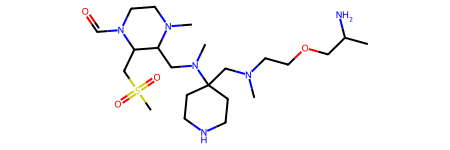

[O][=S][=Branch][=O][pop][Branch][:3butane][Ring2][N][Branch][CH1][pop][CH1][CH1][N][Ring1][#Branch][pop][pop][CH1]


In [244]:
joint_group_selfies=''.join(random.sample(action_space, 9))
rnd_mol = grammar.decoder(joint_group_selfies)
rnd_smiles = Chem.MolToSmiles(rnd_mol)
display(rnd_mol)

print(grammar.full_encoder(rnd_mol))

[11:43:45] Incomplete atom labelling, cannot make bond


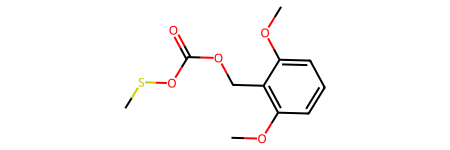

[CH1][O][C][=C][Branch][C][Branch][O][CH1][pop][=CH1][CH1][=CH1][Ring1][O][pop][:0methyl formate][Ring1][O][S][C][pop]


In [239]:
def split_selfies(selfies: str):

    left_idx = selfies.find("[")

    while 0 <= left_idx < len(selfies):
        right_idx = selfies.find("]", left_idx + 1)
        if right_idx == -1:
            raise ValueError("malformed SELFIES string, hanging '[' bracket")

        next_symbol = selfies[left_idx: right_idx + 1]
        yield next_symbol

        left_idx = right_idx + 1
        if selfies[left_idx: left_idx + 1] == ".":
            yield "."
            left_idx += 1

split_gselfis = [list(split_selfies(selfi)) for selfi in action_space]

# # count the number of tokens in each selfi
gselfi_lengths = [len(selfi) for selfi in split_gselfis]

# # combine all tokens from split_selfis into one list
gselfi_alphabet = [token for selfi in split_gselfis for token in selfi]

joint_group_selfies=''.join(random.sample(gselfi_alphabet, 9))
rnd_mol = grammar.decoder(joint_group_selfies)
rnd_smiles = Chem.MolToSmiles(rnd_mol)
display(rnd_mol)

print(grammar.full_encoder(rnd_mol))